### Задача 2: на основе данных выявить поведенчиские шаблоны пьющих и непьющих студентов, можно делать в Jupyter notebook  

In [37]:
import seaborn as sns
import numpy as np
import pandas as pd
import itertools

import statsmodels
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

from IPython.display import display

In [8]:
%pylab inline
sns.set(rc={'figure.figsize':(12.0,8.0)})
pd.set_option('display.max_columns', 500)

Populating the interactive namespace from numpy and matplotlib


# Loading datasets
## Note: (382) students that belong to both datasets

In [85]:
df_mat = pd.read_csv("data/student-mat.csv", sep=";")
print(" data shape, spec: mat: ", df_mat.shape, "\n rows with NA values: ", df_mat.isnull().any(axis=1).sum())

df_por = pd.read_csv("data/student-por.csv", sep=";")
print(" data shape, spec: por: ", df_por.shape, "\n rows with NA values: ", df_por.isnull().any(axis=1).sum())

df = df_por.append(df_mat, ignore_index=True)
print(" data shape, spec: por: ", df.shape, "\n rows with NA values: ", df.isnull().any(axis=1).sum())

 data shape, spec: mat:  (395, 33) 
 rows with NA values:  0
 data shape, spec: por:  (649, 33) 
 rows with NA values:  0
 data shape, spec: por:  (1044, 33) 
 rows with NA values:  0


In [31]:
numeric = ["age", 'Medu', "Fedu", "traveltime", "studytime", "failures",\
           "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences", "G1", "G2", "G3"]

categorical = ["address", "famsize", "Pstatus", "schoolsup", "famsup", "paid",
          "activities", "nursery", "higher", "internet", "romantic",
              'school', 'sex', 'Mjob', 'Fjob', 'guardian', 'reason']

print("checking features:", len(categorical), len(numeric), set(df_mat.columns) - set(numeric) - set(categorical))

checking features: 17 16 set()


# What are the destributions across features

In [41]:
#Age & Sex, mat
display(pd.crosstab(df_mat["sex"],df_mat["age"]))

#Age & Sex, por
display(pd.crosstab(df_por["sex"],df_por["age"]))

#we should drop ones with age >= 20

age,15,16,17,18,19,20,21,22
sex,,,,,,,,
F,38,54,58,43,14,1,0,0
M,44,50,40,39,10,2,1,1


age,15,16,17,18,19,20,21,22
sex,,,,,,,,
F,57,105,113,84,19,4,1,0
M,55,72,66,56,13,2,1,1


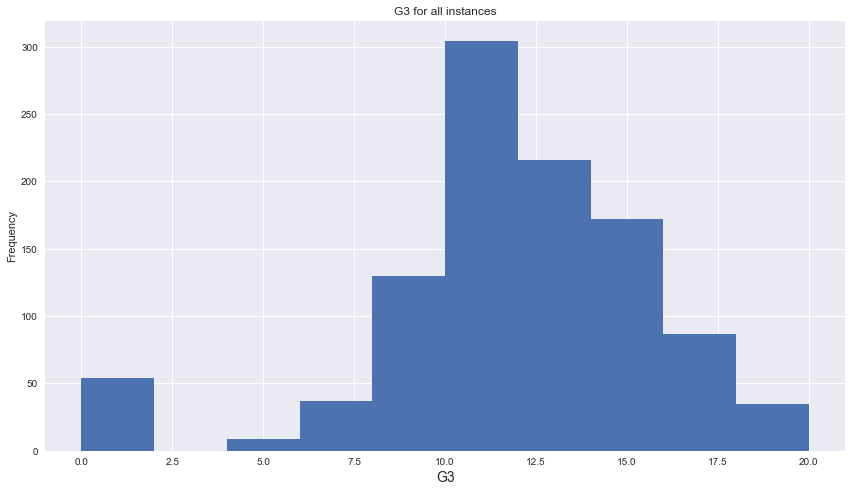

In [94]:
#G3, mat & por
plt.figure(figsize(12,7))

df["G3"].plot.hist()
plt.xlabel('G3', fontsize=14)
plt.title("G3 for all instances")

plt.tight_layout()
pylab.show()

#Here we see the gap between 0 and 5. So, lets think a bit. How dumb you should be to score 0? We could assume that 
#0 is not a score. It's a marker that the student actually didn't attend the exam.

# What are the relations between alcohol consumption and other features?

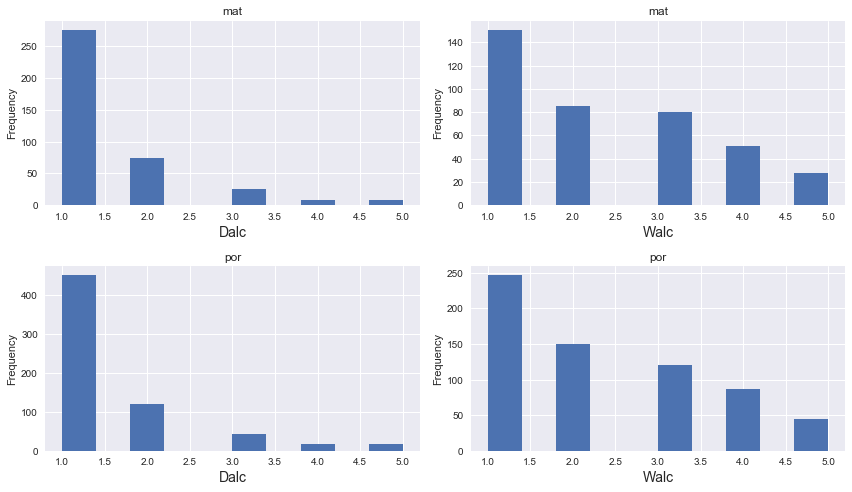

1    276
2     75
3     26
5      9
4      9
Name: Dalc, dtype: int64

1    451
2    121
3     43
5     17
4     17
Name: Dalc, dtype: int64

In [133]:
#Dalc & Walc, mat
plt.figure(figsize(12,7))

plt.subplot(221)
df_mat['Dalc'].plot.hist()
plt.xlabel('Dalc', fontsize=14)
plt.title("mat")

plt.subplot(222)
df_mat['Walc'].plot.hist()
plt.xlabel('Walc', fontsize=14)
plt.title("mat")

#Dalc & Walc, por
plt.subplot(223)
df_por['Dalc'].plot.hist()
plt.xlabel('Dalc', fontsize=14)
plt.title("por")

plt.subplot(224)
df_por['Walc'].plot.hist()
plt.xlabel('Walc', fontsize=14)
plt.title("por")

plt.tight_layout()
pylab.show()

display(df_mat['Dalc'].value_counts())
display(df_por['Dalc'].value_counts())
#Dalc is too skewed, we should encode values 4-5

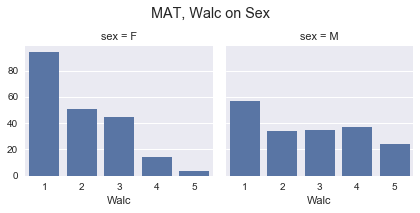

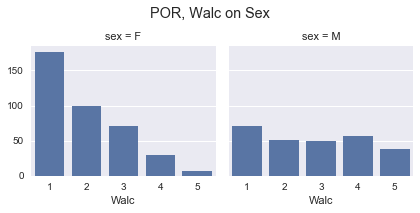

In [134]:
#Walc, mat
g = sns.FacetGrid(df_mat, col="sex")
g = g.map(sns.countplot, "Walc")
plt.subplots_adjust(top=0.8)
g.fig.suptitle('MAT, Walc on Sex')

#Walc, por
g = sns.FacetGrid(df_por, col="sex")
g = g.map(sns.countplot, "Walc")
plt.subplots_adjust(top=0.80)
g.fig.suptitle('POR, Walc on Sex')

sns.plt.show()
#Not proven but, it seems like on average higher Walc corresponds to Males.
#So, it's ok, Males Have a Higher Alcohol Tolerance. Ideally values should be normed on sex.
#And there is no differences between MAT and POR

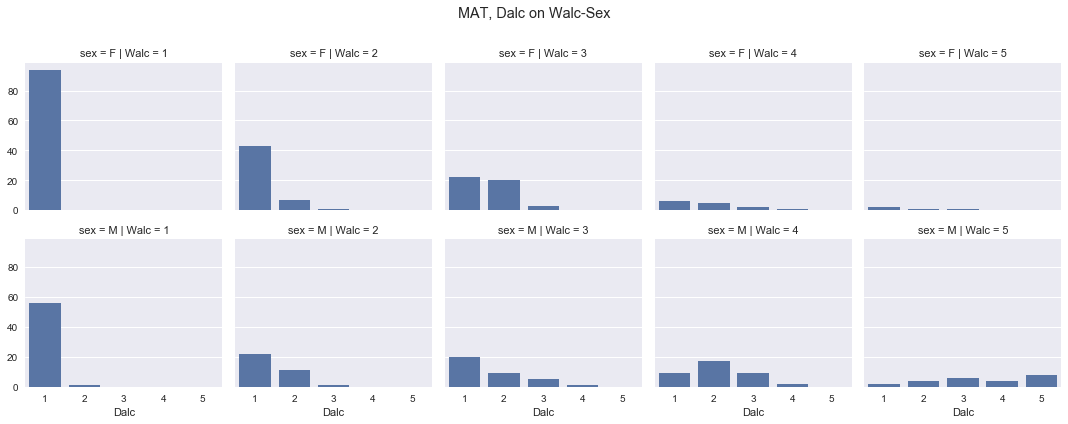

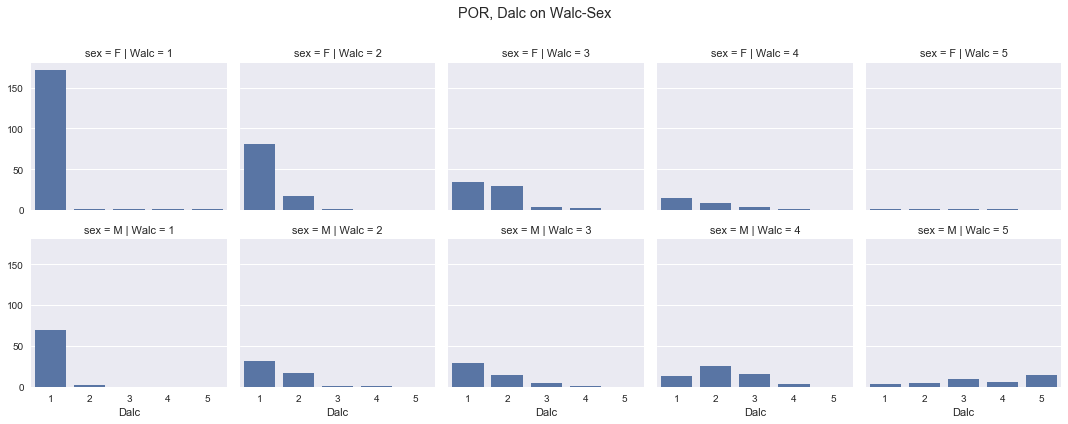

In [132]:
g = sns.FacetGrid(df_mat, col='Walc', row="sex")
g = g.map(sns.countplot, "Dalc")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('MAT, Dalc on Walc-Sex')

g = sns.FacetGrid(df_por, col='Walc', row="sex")
g = g.map(sns.countplot, "Dalc")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('POR, Dalc on Walc-Sex')

sns.plt.show()
#Same story with Dalc. Higher Dalc values are common for Males with High Walc.

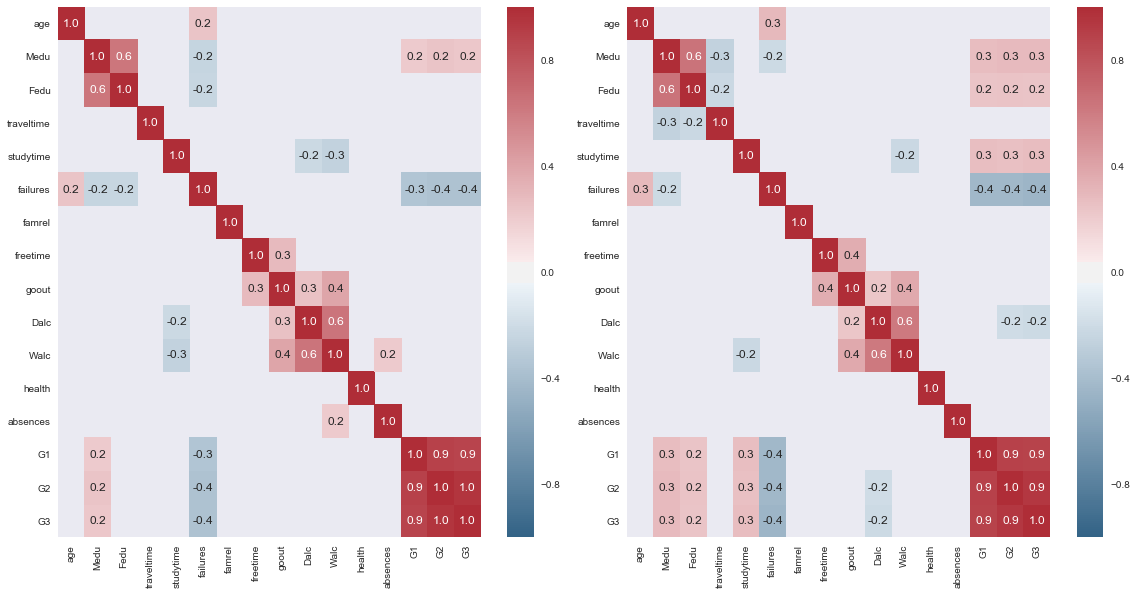

In [152]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig.tight_layout()

#correlations for numeric variables, mat
cmap = sns.diverging_palette(240, 10, s=75, l=40, as_cmap=True)
mask = df_mat[numeric].corr(method="spearman").abs() < 0.2
ax = sns.heatmap(df_mat[numeric].corr(method="spearman"), cmap=cmap, mask=mask,
                annot=True, fmt=".1f", ax=axs[0])

#correlations for numeric variables, por
cmap = sns.diverging_palette(240, 10, s=75, l=40, as_cmap=True)
mask = df_por[numeric].corr(method="spearman").abs() < 0.2
ax = sns.heatmap(df_por[numeric].corr(method="spearman"), cmap=cmap, mask=mask,
                annot=True, fmt=".1f", ax=axs[1])

sns.plt.show()

Посмотрим на матрицу диаграмм рассеяния по количественным признакам:

In [154]:
#Посчитаем коэффициенты V Крамера
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests 
chi2_test = pd.DataFrame(columns=['first', 'second', 'cramer_v', 'pvalue'])

for ind, (f, s) in enumerate(itertools.combinations(categorical, 2)):   
    data = pd.crosstab(df_mat[f],df_mat[s])
    
    chi2, pvalue = chi2_contingency(data)[:2]
    n, dim = data.as_matrix().sum(), min(data.shape) - 1
    cramer_v = np.sqrt(chi2 / n / dim)
    
    chi2_test.loc[ind] = [f, s, cramer_v, pvalue]

#Введём поправку на множетсвенное тестирование методом холма
reject, p_corrected, a1, a2 = multipletests(chi2_test.pvalue, 
                                            alpha = 0.05, 
                                            method = 'holm')
chi2_test['p_corrected'] = p_corrected
chi2_test['reject'] = reject

#Посмотрим что получили
print("H rejected without multiple tsting correction:", (chi2_test.pvalue <= 0.05).sum())
print("H rejected with multiple tsting correction:", (chi2_test.p_corrected <= 0.05).sum())
chi2_test[chi2_test.reject == True]

H rejected without multiple tsting correction: 29
H rejected with multiple tsting correction: 5


,first,second,cramer_v,pvalue,p_corrected,reject
8,address,internet,0.208688,3.359865e-05,4.435022e-03,True
10,address,school,0.270313,7.770684e-08,1.041272e-05,True
58,famsup,paid,0.287969,1.044904e-08,1.410620e-06,True
111,internet,Mjob,0.270308,8.341138e-06,1.109371e-03,True
130,Mjob,Fjob,0.215508,2.533577e-09,3.445664e-07,True


In [155]:
#Посчитаем коэффициенты V Крамера
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests 
chi2_test = pd.DataFrame(columns=['first', 'second', 'cramer_v', 'pvalue'])

for ind, (f, s) in enumerate(itertools.combinations(categorical, 2)):   
    data = pd.crosstab(df_por[f],df_por[s])
    
    chi2, pvalue = chi2_contingency(data)[:2]
    n, dim = data.as_matrix().sum(), min(data.shape) - 1
    cramer_v = np.sqrt(chi2 / n / dim)
    
    chi2_test.loc[ind] = [f, s, cramer_v, pvalue]

#Введём поправку на множетсвенное тестирование методом холма
reject, p_corrected, a1, a2 = multipletests(chi2_test.pvalue, 
                                            alpha = 0.05, 
                                            method = 'holm')
chi2_test['p_corrected'] = p_corrected
chi2_test['reject'] = reject

#Посмотрим что получили
print("H rejected without multiple tsting correction:", (chi2_test.pvalue <= 0.05).sum())
print("H rejected with multiple tsting correction:", (chi2_test.p_corrected <= 0.05).sum())
chi2_test[chi2_test.reject == True]

H rejected without multiple tsting correction: 42
H rejected with multiple tsting correction: 15


,first,second,cramer_v,pvalue,p_corrected,reject
8,address,internet,0.171829,1.200956e-05,1.537224e-03,True
10,address,school,0.351003,3.823217e-19,5.161343e-17,True
12,address,Mjob,0.204820,1.788954e-05,2.271972e-03,True
15,address,reason,0.172262,2.417246e-04,2.997386e-02,True
16,famsize,Pstatus,0.234474,2.324542e-09,3.045150e-07,True
43,Pstatus,guardian,0.170889,7.663935e-05,9.579918e-03,True
90,activities,reason,0.169502,3.235211e-04,3.946958e-02,True
104,higher,Mjob,0.199574,3.393427e-05,4.275719e-03,True
106,higher,guardian,0.198109,2.944159e-06,3.797966e-04,True
109,internet,school,0.236659,1.649843e-09,2.177793e-07,True


# Counting E(X1|X2 = 1) - E(X1|X2 = 0) for binary features

In [16]:
df["Walc"].mean()

2.282051282051282

In [17]:
def count_expected_value(df, col, target):
    values = df.groupby(by=col)[target].sum() / df.groupby(by=col)[target].count()
    return np.abs(values[0] - values[1]) / df[target].mean()

diff = []
for col in categorical:
    if (df[col].unique().shape[0]) != 2:
        #not binary
        diff.append([-1, -1, -1, -1, -1, -1, col])
    else:
        #binary
        values = [count_expected_value(df, col, target) for target in ["Walc", "Dalc", "failures", "G1", "G2", "G3"]]
        values.append(col)
        diff.append(values)
        
res = pd.DataFrame(diff, columns=["diff_Walc", "diff_Dalc", "diff_failures", "diff_G1", "diff_G2", "diff_G3", "col"])\
    .sort_values(by="diff_Walc", ascending=False)
condition = (res[["diff_Walc", "diff_Dalc"]] > 0).any(axis=1)    
res = res[condition].set_index(keys="col")

res

,diff_Walc,diff_Dalc,diff_failures,diff_G1,diff_G2,diff_G3
col,,,,,,
sex,0.299492,0.302858,0.123545,0.059332,0.066322,0.094349
higher,0.209497,0.082458,3.016682,0.234190,0.286309,0.370433
schoolsup,0.142190,0.025718,0.075439,0.192483,0.122136,0.107406
address,0.139136,0.137660,0.415461,0.049561,0.102747,0.106698
nursery,0.133427,0.096322,0.338115,0.050564,0.056886,0.054535
famsize,0.120817,0.132387,0.053720,0.051439,0.066715,0.083256
school,0.101614,0.179302,0.045848,0.028314,0.054498,0.063595
famsup,0.098230,0.025044,0.210451,0.054269,0.042737,0.036049
paid,0.070193,0.084108,0.891077,0.023148,0.075027,0.090271


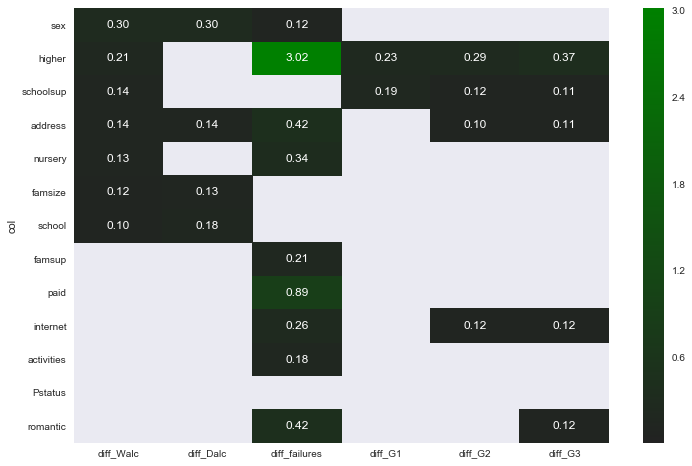

In [18]:
cmap = sns.dark_palette("green", as_cmap=True)
mask = res <= 0.1
ax = sns.heatmap(res, cmap=cmap, mask=mask,
                annot=True, fmt=".2f")

In [22]:
#so, values to check further are:
res

,diff_Walc,diff_Dalc,diff_failures,diff_G1,diff_G2,diff_G3
col,,,,,,
sex,0.299492,0.302858,0.123545,0.059332,0.066322,0.094349
higher,0.209497,0.082458,3.016682,0.234190,0.286309,0.370433
schoolsup,0.142190,0.025718,0.075439,0.192483,0.122136,0.107406
address,0.139136,0.137660,0.415461,0.049561,0.102747,0.106698
nursery,0.133427,0.096322,0.338115,0.050564,0.056886,0.054535
famsize,0.120817,0.132387,0.053720,0.051439,0.066715,0.083256
school,0.101614,0.179302,0.045848,0.028314,0.054498,0.063595
famsup,0.098230,0.025044,0.210451,0.054269,0.042737,0.036049
paid,0.070193,0.084108,0.891077,0.023148,0.075027,0.090271


In [ ]:
#Check data for representativity
for col in categorical:
    print(col)
    print(df[col].value_counts(), "\n")